# Prototypical Networks
---

## Import Libraries

In [1]:
import sys
sys.path.append("../")
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

%matplotlib inline

In [3]:
from configs.base_config import base_config as CONFIG
from meta_infomax.trainers.protonet_trainer import ProtonetTrainer
from meta_infomax.datasets.fudan_reviews import MultiTaskDataset

# Load Pretrained Model and Data

In [4]:
config = {
    'exp_name': "protonet_default",
    'device': 'cpu',
    'data_dir': '../data/mtl-dataset/',
    'trainer': 'prototypical',
    'num_training_examples': 14000,
    'n_support': 5,
    'n_query': 5,
    'n_test_query': 10,
    'freeze_until_layer': 10,
}
CONFIG.update(config)

In [5]:
trainer = ProtonetTrainer(CONFIG)

INFO:root:Config Setting:
{'trainer': 'prototypical', 'lr': 5e-05, 'weight_decay': 0.01, 'warmup_steps': 100, 'collapse_domains': True, 'epochs': 3, 'batch_size': 16, 'valid_freq': 10, 'save_freq': 100, 'unfreeze_layers': (10, 11), 'clip_grad_norm': 1, 'validation_size': 0, 'random_state': 42, 'device': 'cpu', 'data_dir': '../data/mtl-dataset/', 'transformer_name': 'bert-base-uncased', 'domains': ['apparel', 'baby', 'books', 'camera_photo', 'electronics', 'health_personal_care', 'imdb', 'kitchen_housewares', 'magazines', 'music', 'software', 'sports_outdoors', 'toys_games', 'video', 'MR', 'dvd'], 'train_domains': ['apparel', 'baby', 'books', 'camera_photo', 'electronics', 'health_personal_care', 'kitchen_housewares', 'magazines', 'music', 'software', 'sports_outdoors', 'toys_games', 'video', 'dvd'], 'val_domains': ['imdb'], 'test_domains': ['MR'], 'log_level': 20, 'log_freq': 100, 'exp_name': 'protonet_default', 'num_training_examples': 14000, 'n_support': 5, 'n_query': 5, 'n_test_quer

In [6]:
for param in trainer.model.bert_encoder.embeddings.parameters():
    print(param.requires_grad)

False
False
False
False
False


In [7]:
for param in trainer.model.bert_encoder.pooler.parameters():
    print(param.requires_grad)

True
True


In [8]:
for bert_layer in trainer.model.bert_encoder.encoder.layer:
    print([param.requires_grad for param in bert_layer.parameters()])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, Fals

In [9]:
model = trainer.model
train_dls = trainer.train_dls
val_dls = trainer.val_dls
test_dls = trainer.test_dls

# Test

In [10]:
domain_dataloader = test_dls[0]

In [11]:
pos_dl, neg_dl = domain_dataloader

In [12]:
pos_dl.batch_size, len(pos_dl)

(10, 83)

In [13]:
neg_dl.batch_size, len(neg_dl)

(10, 78)

In [14]:
neg_batch = next(iter(domain_dataloader[0]))
pos_batch = next(iter(domain_dataloader[1]))

pos_support_x = pos_batch['x'][:config['n_support']]
neg_support_x = neg_batch['x'][:config['n_support']]
pos_support_masks = pos_batch['masks'][:config['n_support']]
neg_support_masks = neg_batch['masks'][:config['n_support']]

In [15]:
pos_support_x

tensor([[  101,  1996,  2143,  ...,     0,     0,     0],
        [  101,  2066,  2049,  ...,     0,     0,     0],
        [  101,  2887,  2472,  ...,     0,     0,     0],
        [  101,  1037, 23624,  ...,     0,     0,     0],
        [  101,  2005,  2320,  ...,     0,     0,     0]])

In [16]:
neg_support_x

tensor([[  101,  2009,  1005,  ...,     0,     0,     0],
        [  101,  2043,  1037,  ...,     0,     0,     0],
        [  101,  2012,  2335,  ...,     0,     0,     0],
        [  101,  1996, 25957,  ...,     0,     0,     0],
        [  101,  1996,  3185,  ...,     0,     0,     0]])

In [17]:
pos_prototype = model(pos_support_x, pos_support_masks)
neg_prototype = model(neg_support_x, neg_support_masks)

In [18]:
pos_prototype.shape, neg_prototype.shape

(torch.Size([5, 256]), torch.Size([5, 256]))

In [19]:
n_episodes = len(pos_dl) if len(pos_dl) > len(neg_dl) else len(neg_dl)

In [20]:
#for i in range(n_episodes):
episode, domain = trainer._prepare_episode(domain_dataloader)

In [21]:
episode[0].shape

torch.Size([20, 512])

In [22]:
x, masks = episode
x = x.to(trainer.config['device'])
masks = masks.to(trainer.config['device'])

In [23]:
x_embeds = model(x, masks)

In [24]:
x_embeds.shape

torch.Size([20, 256])

In [25]:
x = torch.cat([pos_prototype, x_embeds[:trainer.config['n_test_query'],:], 
               neg_prototype, x_embeds[trainer.config['n_test_query']:,:]])

In [27]:
trainer.prototypical_loss(x, n_support=trainer.config['n_support'], n_query=trainer.config['n_test_query'])

(tensor(0.6971, grad_fn=<NegBackward>), tensor(0.5000))

# Visualize Prototypes

## Batches from domains

In [12]:
def prepare_batch(domain_dataloader):
    neg_batch = next(iter(domain_dataloader[0]))
    pos_batch = next(iter(domain_dataloader[1]))
    batch_x = torch.cat([neg_batch['x'], pos_batch['x']])
    batch_masks = torch.cat([neg_batch['masks'], pos_batch['masks']])
    batch_labels = np.concatenate([neg_batch['labels'], pos_batch['labels']])
    batch_domains = np.concatenate([neg_batch['domains'], pos_batch['domains']])
    return batch_x, batch_masks, batch_labels, batch_domains

## Get embeddings

In [46]:
embeds = []
labels = []
domains = []

In [48]:
for domain_dl in np.concatenate([train_dls[0], train_dls[1], test_dls[0]]):
    batch_x, batch_masks, batch_labels, batch_domains = prepare_batch(domain_dl)
    with torch.no_grad():
        batch_embed = model(batch_x, batch_masks)
    embeds.append(batch_embed.detach().numpy())
    labels.append(batch_labels)
    domains.append(batch_domains)

TypeError: 'DataLoader' object does not support indexing

In [15]:
embeds = np.concatenate(embeds)
labels = np.concatenate(labels)
domains = np.concatenate(domains)

In [44]:
embeds.shape, labels.shape, domains.shape

((100, 256), (100,), (100,))

## 2D projection of embeddings

In [19]:
embeds_2d = TSNE(n_components=2).fit_transform(embeds)

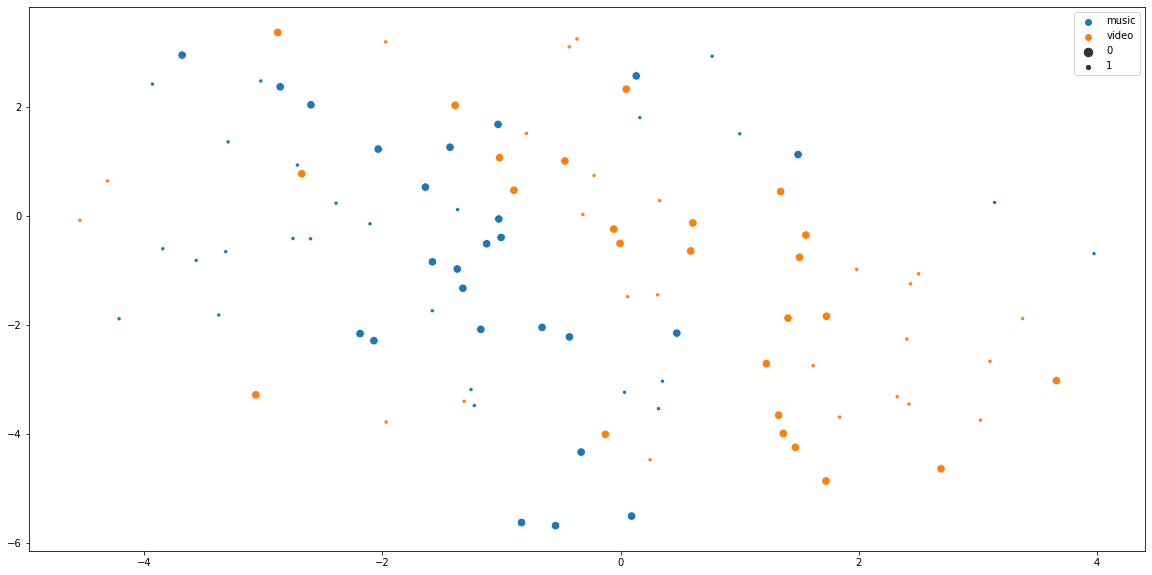

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x=embeds_2d[:,0], y=embeds_2d[:,1], hue=domains, size=labels)